<a href="https://colab.research.google.com/github/travislatchman/Cardiac-Ultrasound-Image-Segmentation-and-Stroke-Volume-estimation/blob/main/Cardiac_Task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

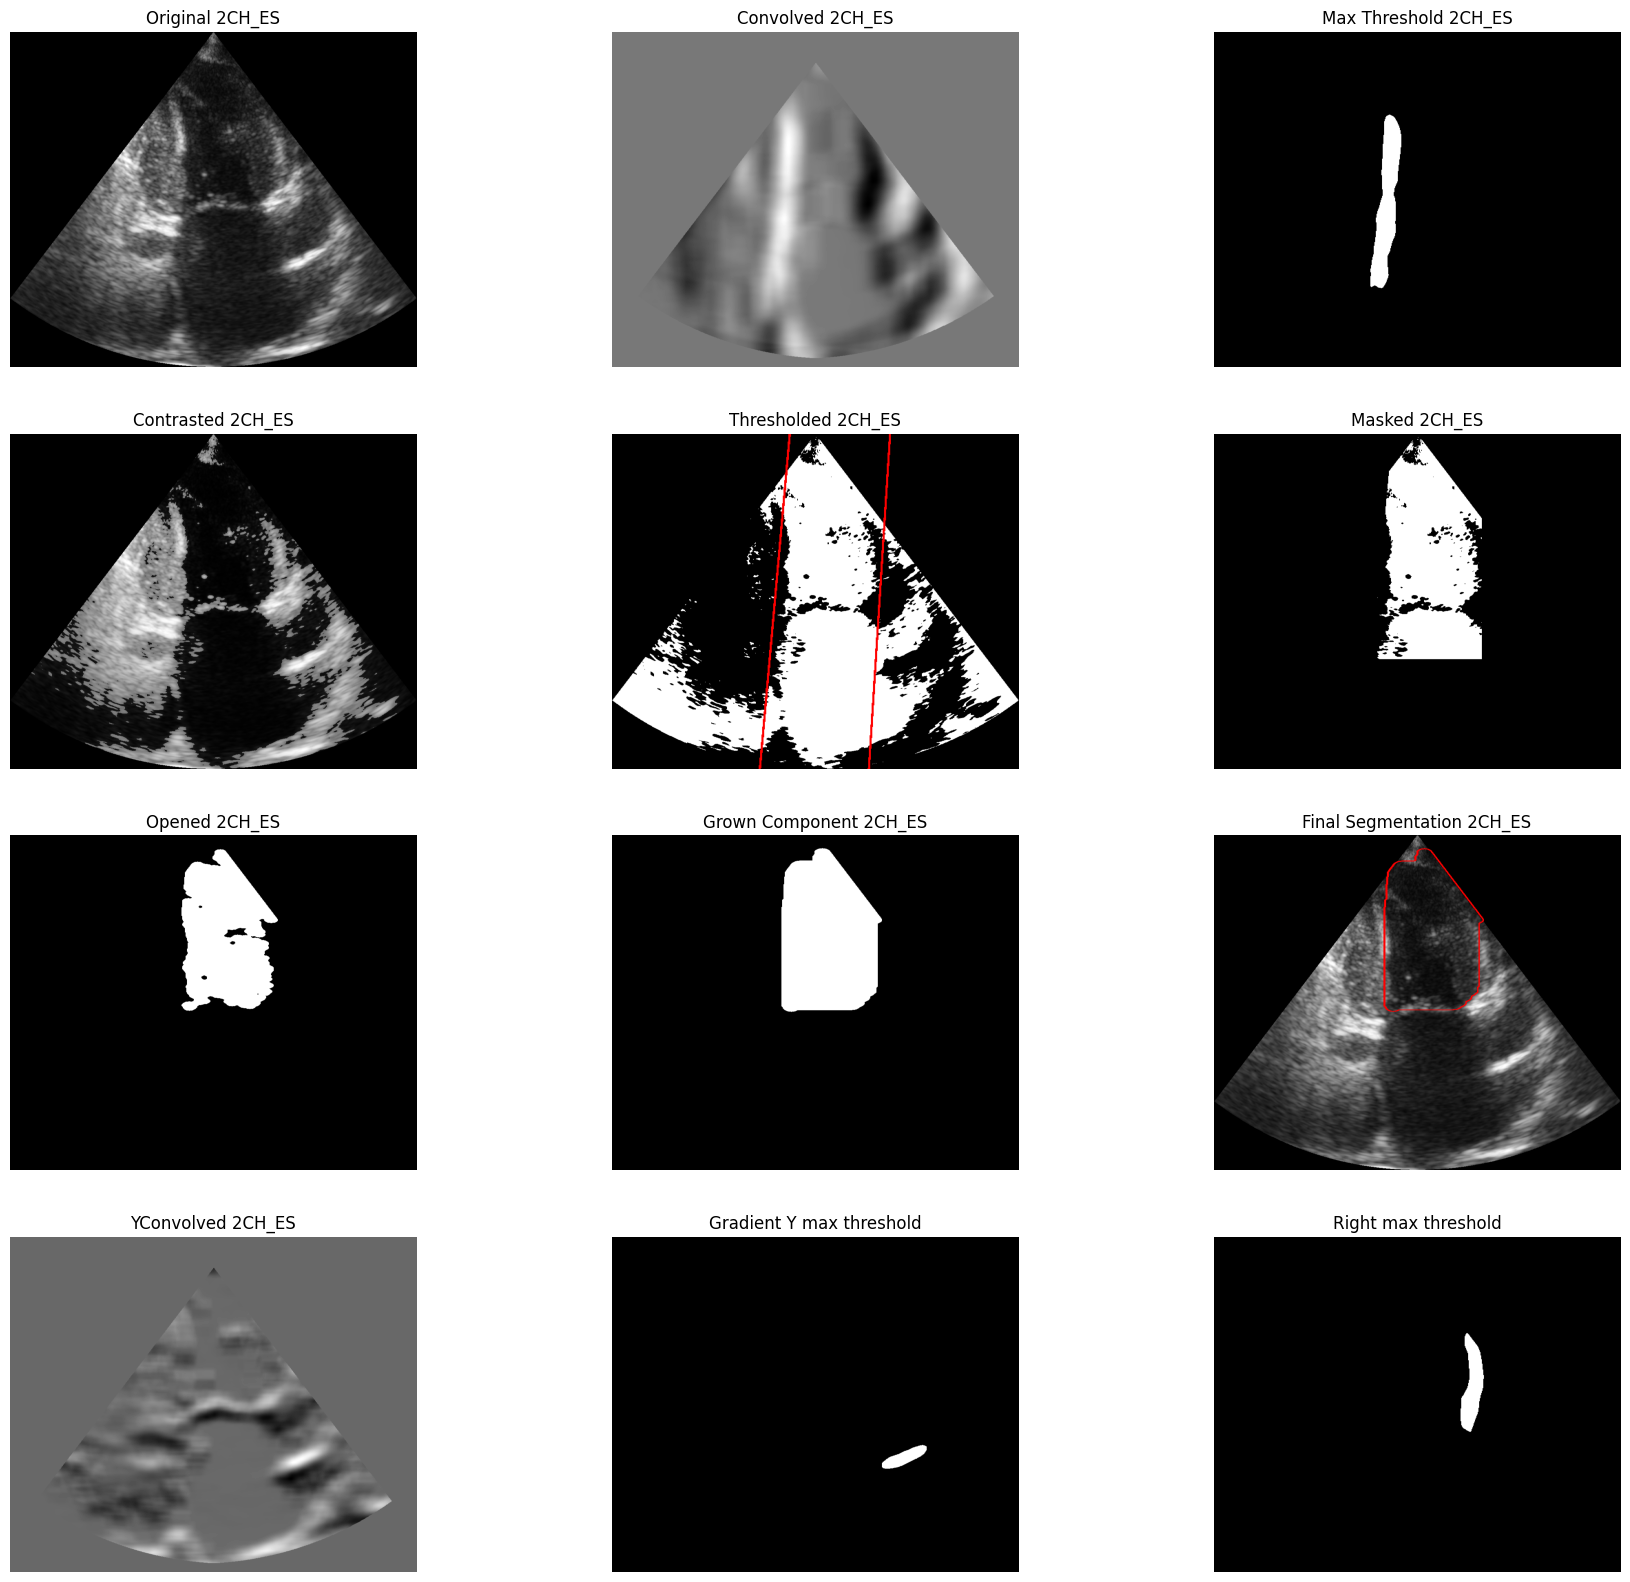

In [16]:
import Segmentation as Seg

exampleFile = '2CH_ES'
ED_2CH, aspect = Seg.read_patient_mhd_file(5, exampleFile)
ED_2CH = ED_2CH[0]
boundary, region = Seg.segmentImage(ED_2CH, aspect, exampleFile, True, False)

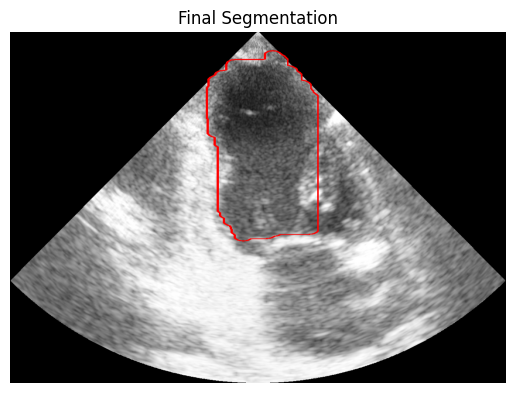

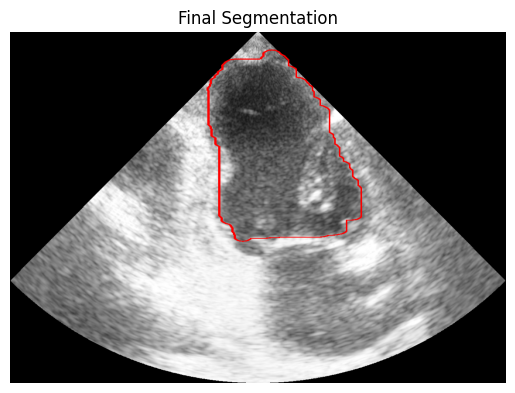

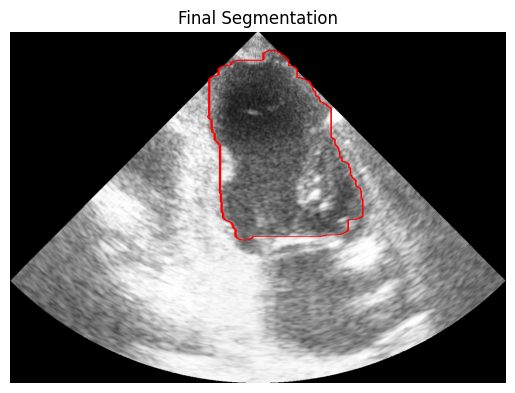

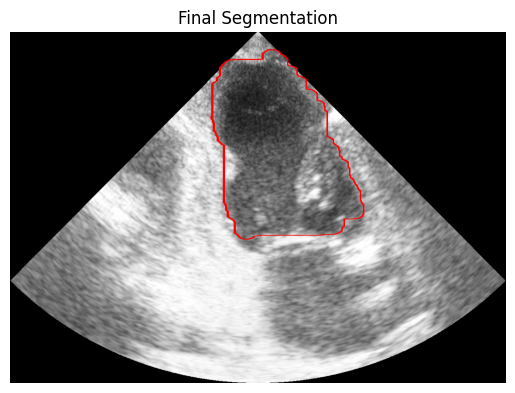

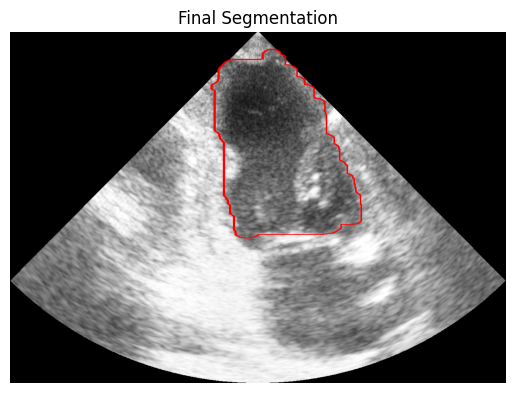

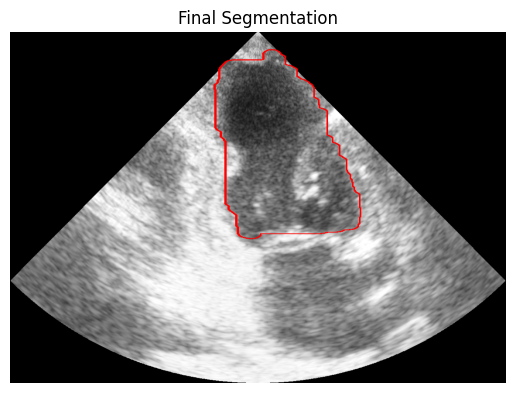

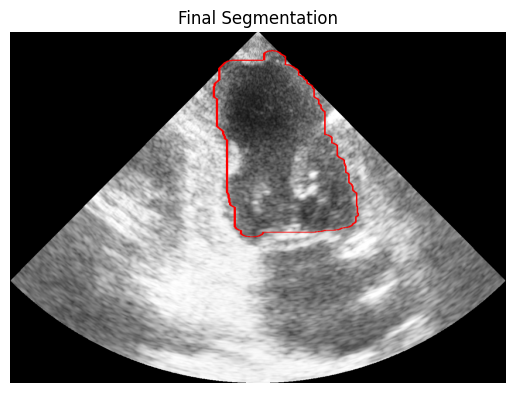

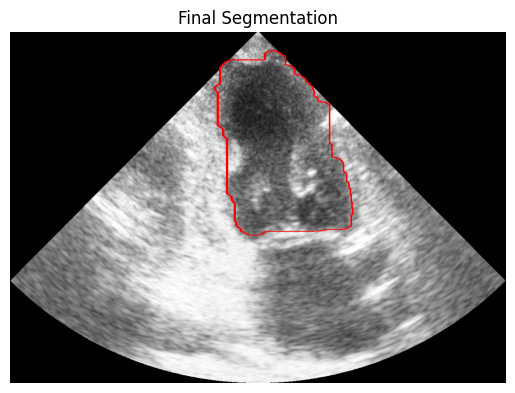

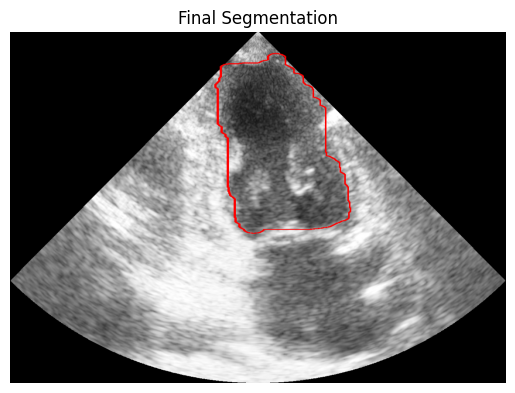

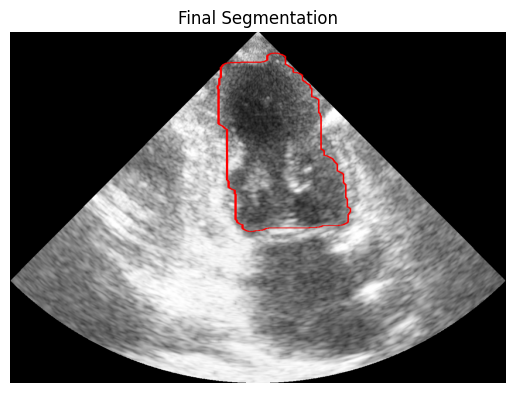

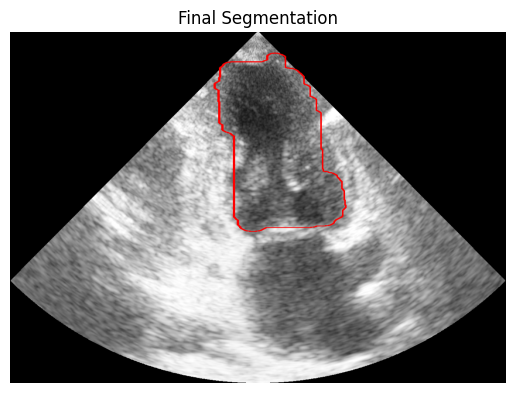

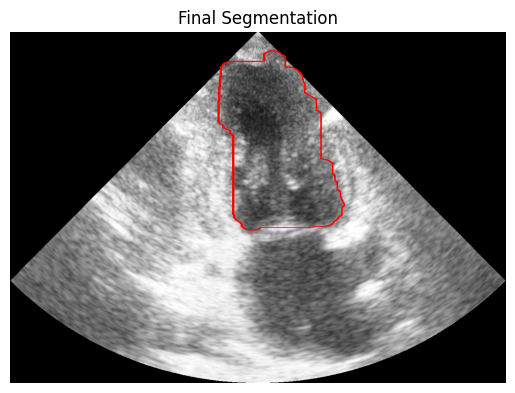

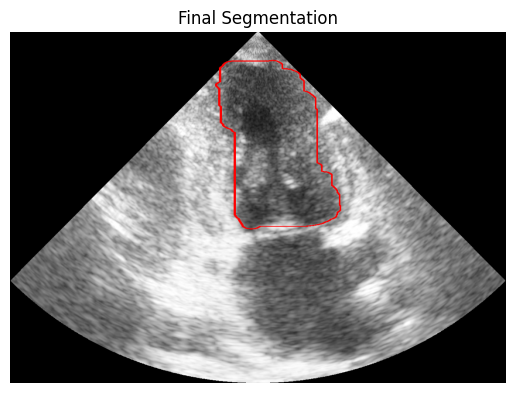

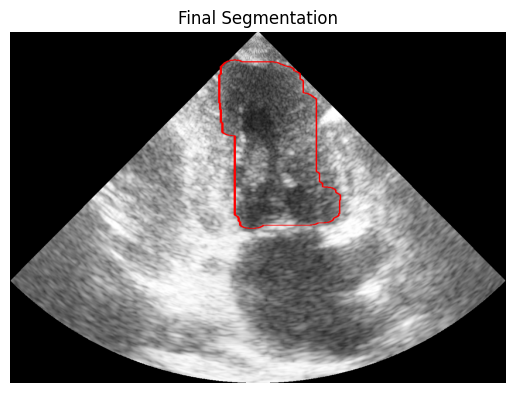

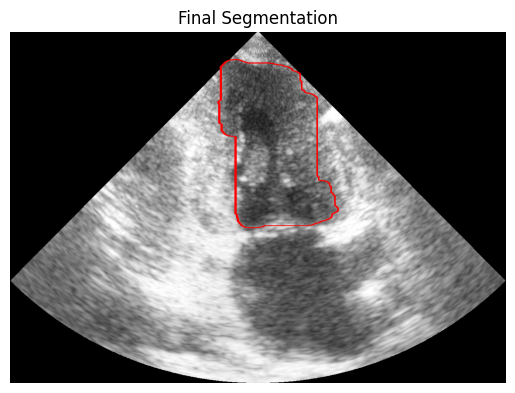

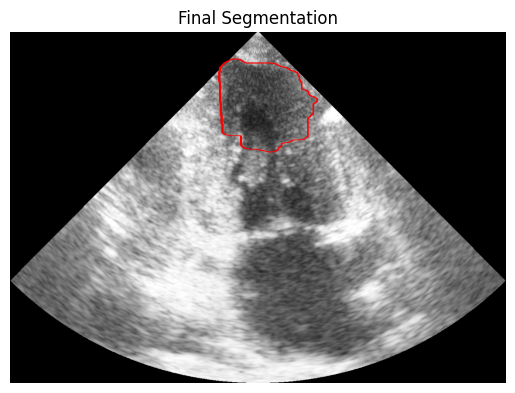

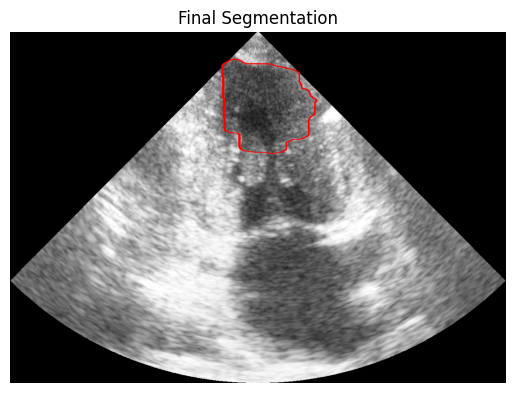

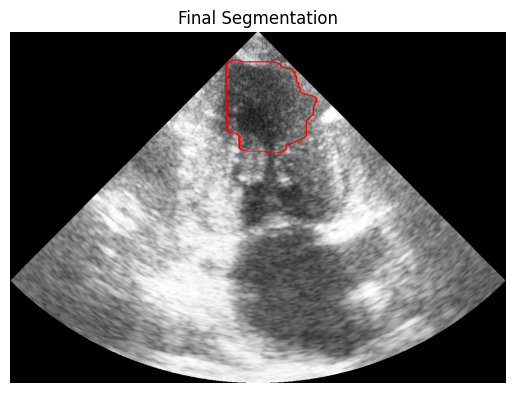

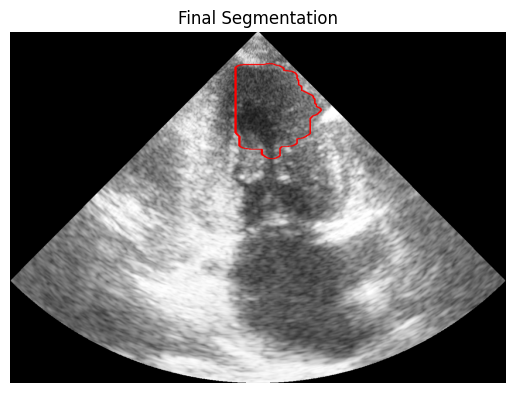

In [21]:
import Segmentation as Seg

exampleFile = '2CH_sequence'
image, aspect = Seg.read_patient_mhd_file(4, exampleFile) #Look at 1, 4 ,14, 16
        
for i in range(len(image)):
    boundary, region = Seg.segmentImage(image[i], aspect, exampleFile, False, True)

In [22]:
import numpy as np
import Segmentation as Seg

def diceCoefficient(im1, im2): #Ones in mask, zero elsewhere
    assert(im1.shape == im2.shape)
    intersection = np.sum(im1 * im2)
    return 2 * intersection / (np.sum(im1) + np.sum(im2))


totalNum = 0
diceSum = 0
for patientNumber in range(1, 10):
    print(patientNumber)
    for title in ['2CH_ED', '2CH_ES', '4CH_ED', '4CH_ES']:
        image, aspect = Seg.read_patient_mhd_file(patientNumber, title)
        image = image[0] 
        b, region = Seg.segmentImage(image, aspect, title, False, False)
        region[region > 0] = 1 #Make sure range is 0, 1
        
        
        gt, aspect = Seg.read_patient_mhd_file(patientNumber, title + '_gt')
        gt = gt[0]
        gt[gt != 1] = 0
        
        diceSum += diceCoefficient(region, gt)
        totalNum += 1
print(diceSum / totalNum)
        

1
2
3
4
5
6
7
8
9
0.7151750112235697
